# Crypto Currency Cross-Prediction 03

This time the data would be preprocessed to be the change of price w.r.t. the previous day.

```
C(t) = (P(t) - P(t-1)) / P(t-1)
C - change ratio
P - price
t - time (day)
```

- Model: N-Beat

In [1]:
from datetime import datetime
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras import layers
from util import *
from nbeat import *

In [2]:
def preprocessChangeRatio(data):
  return np.array([(data[i] - data[i - 1]) / data[i - 1] for i in range(1, len(data))])

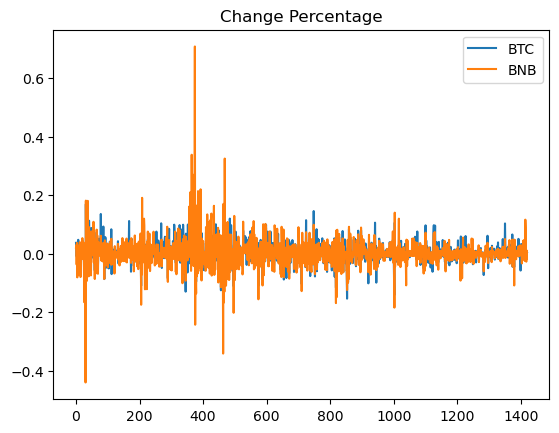

In [3]:
btc_data = pd.read_csv('data/BTCUSDT_1D_2.csv')
bnb_data = pd.read_csv('data/BNBUSDT_1D_2.csv')

btc_ch_data = preprocessChangeRatio(btc_data["Close"])
bnb_ch_data = preprocessChangeRatio(bnb_data["Close"])

plt.plot(btc_ch_data, label="BTC")
plt.plot(bnb_ch_data, label="BNB")
plt.title("Change Percentage")
plt.legend()

In [4]:
dataSize = len(btc_ch_data)
assert(dataSize == len(bnb_ch_data))
windowSize = 35
testSize = round(dataSize * 0.3)
print(f"dataSize: {dataSize}")
print(f"windowSize: {windowSize}")
print(f"testSize: {testSize}")

dataSize: 1420
windowSize: 35
testSize: 426


#### Trivial (Brenchmark)

Change prediction of trivial model is always 0

In [ ]:
y_test = prepareTestingOutputs(btc_ch_data, testSize)
prediction0 = np.array([0 for _ in range(0, testSize)])

rmse0 = tf.keras.metrics.RootMeanSquaredError()(y_test, prediction0)
print(f"RootMeanSquaredError {rmse0}")
# no correlation can be found by the series without change
# corr0 = np.corrcoef(prediction0, y_test)[0, 1]
# print(f"Correlation {corr0}")

RootMeanSquaredError 0.024526631459593773


#### [Model1] BNB -> BNB

In [10]:
x_train = prepareTrainingInputs(bnb_ch_data, windowSize, testSize)
y_train = prepareTraingingOutputs(bnb_ch_data, windowSize, testSize)
x_test = prepareTestingInputs(bnb_ch_data, windowSize, testSize)
y_test = prepareTestingOutputs(bnb_ch_data, testSize)

In [12]:
train_dataset, test_dataset = prepareDataSetFromArray(x_train, y_train, x_test, y_test)

nbeatNeuronCount = 512
nBeatLayerCount = 4
nBeatStackCount = 30

# Create input to stacks
input = layers.Input(shape=windowSize, name="stack_input")
x = input
x = buildNBeatLayers(windowSize, windowSize+1, 1, nbeatNeuronCount, nBeatLayerCount, nBeatStackCount, x)

model1 = tf.keras.Model(inputs=input, outputs=x)
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 stack_input (InputLayer)       [(None, 35)]         0           []                               
                                                                                                  
 InitialBlock (NBeatsBlock)     ((None, 35),         824868      ['stack_input[0][0]']            
                                 (None, 1))                                                       
                                                                                                  
 nbeat_subtract_00 (Subtract)   (None, 35)           0           ['stack_input[0][0]',            
                                                                  'InitialBlock[0][0]']           
                                                                                            

In [14]:
model1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

history1 = model1.fit(train_dataset,
            epochs=5000, # just a large number
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True, verbose=1),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 129: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Restoring model weights from the end of the best epoch: 29.

Epoch 229: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 229: early stopping


14/14 [==============================] - 0s 26ms/step - loss: 0.0177 - mae: 0.0177 - mse: 7.5843e-04
rmse1: 0.027539625610181185


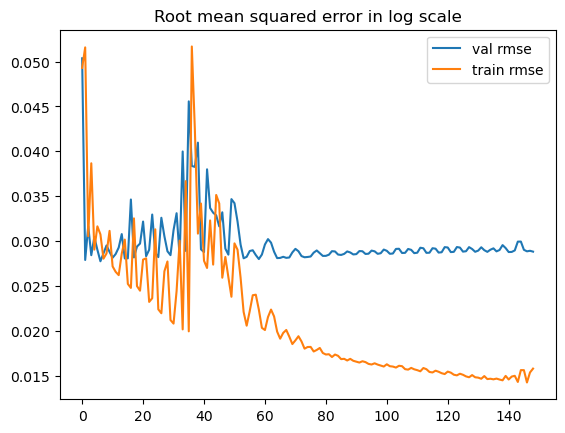

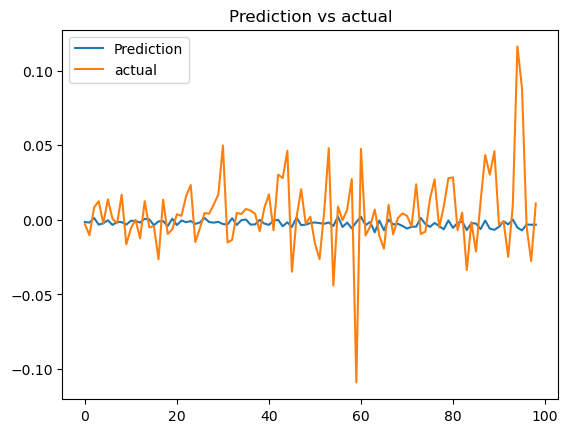

In [19]:
rmse1 = np.sqrt(model1.evaluate(np.array(x_test), y_test)[2])
print(f"rmse1: {rmse1}")

# plot error
plotHistoryRSME(history1)
plt.figure()

# plot prediction for last 100 days
prediction5 = model1.predict(np.array(x_test[-100:-1]))
plt.plot(prediction5, label='Prediction')
plt.plot(y_test[-100:-1], label='actual')
plt.title('Prediction vs actual')
plt.legend()

The daily change is too vary to be predicted. Next time change the prediction target as average of next few days.